# Imports

In [825]:

import pandas as pd
import numpy as np
import math
from itertools import product
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from time import sleep
import os

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num, num2date
from collections import defaultdict
from scipy import stats
from collections import Counter
from typing import NamedTuple


In [2]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df.set_index('time', inplace=True)
df.index = pd.DatetimeIndex(df.index * 1e+9)

In [48]:
df

,open,high,low,close,volume,trades
time,,,,,,
2020-01-08 15:25:00,8300.00,8300.00,8300.00,8300.00,0.002000,1
2020-01-08 15:30:00,8300.00,8300.00,8300.00,8300.00,0.000410,1
2020-01-08 16:05:00,8217.51,8217.51,8217.51,8217.51,0.009630,1
2020-01-08 16:20:00,8217.51,8217.51,8217.51,8217.51,0.002660,1
2020-01-08 17:40:00,7900.01,7900.01,7900.01,7900.01,0.014154,3
...,...,...,...,...,...,...
2021-03-31 23:25:00,58900.07,58900.14,58900.07,58900.14,0.170260,3
2021-03-31 23:30:00,58893.99,58965.53,58893.99,58964.45,0.244470,5
2021-03-31 23:35:00,58855.02,58855.02,58800.00,58800.00,0.120773,3


In [ ]:
class Trader1:
    # Bollinger: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Using%20the%20bands%20as%20overbought,have%20deviated%20from%20the%20mean.
    def __init__(self, n_cycles, n_devs, qty, take_at=0.005, fee=0.0026):
        # qty = quantity to trade at a time
        # EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier)
        # 
        # BOLU=MA(TP,n)+m∗σ[TP,n]
        # BOLD=MA(TP,n)−m∗σ[TP,n]
        # where:
        # BOLU=Upper Bollinger Band
        # BOLD=Lower Bollinger Band
        # MA=Moving average
        # TP (typical price)=(High+Low+Close)÷3
        # n=Number of cycles in smoothing period ... n_cycles
        # m=Number of standard deviations ... n_devs
        # σ[TP,n]=Standard Deviation over last n periods of TP
        #
        # take_at = take profit at p0 * (1 + someting% + 2*fee)
        self.N = n_cycles
        self.M = n_devs
        self.qty = qty
        self.take_at = take_at
        self.fee = fee
        self.prices = np.array([0.] * self.N)
        
        self.sma = None
        self.upper = None
        self.lower = None
        self.var = None
        self.std = None
        self.open_price = None
        self.profit_price = None
        self.loss_price = None
    
        self.position = 0
        self.trades = []
        
        self.warming_up = True
        self.i = 0
    
    def update(self, cycle, ohlc: dict, price):
        _, high, low, close = self._unpack(ohlc)

        last_price = self.prices[self.i]
        self.prices[self.i] = price
        self.i += 1
        if self.i == len(self.prices):
            self.i = 0
            if self.warming_up:
                self.warming_up = False
                self.sma = np.mean(self.prices)
                self.var = np.var(self.prices)
                self.std = math.sqrt(self.var)
                self.upper = self.sma + self.M * self.std
                self.lower = self.sma - self.M * self.std
                return

        if not self.warming_up:
            old_sma = self.sma
            self.sma += (price - last_price) / self.N
            self.var += (price - self.sma + last_price - old_sma)*(price - last_price)/(self.N)
            self.var = self.check_var(self.var)
            self.std = math.sqrt(self.var)
            self.upper = self.sma + self.M * self.std
            self.lower = self.sma - self.M * self.std
            
    def check(self, x):
        if np.abs(x) > 0.01:
            raise
    
    def check_var(self, var):
        if var < 0:
            if abs(var) >= 1.e-4:
                raise Exception(f'var was {var}')
            return 0.
        return var
    
    def trade(self) -> float:  # return number of shares to trade
        if self.warming_up:
            return None
        price = self.prices[self.i]
        # buy
        if price < self.lower and self.position <= 0:
            if self.position == 0:
                self.open_price = price
                self.profit_price = price + self.take_at + 2*self.fee
                self.loss_price = price - (self.take_at + 2*self.fee)
            self.position += self.qty
            return self.qty
    
        # sell
        if price > self.upper and self.position >= 0:
            if self.position == 0:
                self.open_price = price
                self.loss_price = price + self.take_at + 2*self.fee
                self.profit_price = price - (self.take_at + 2*self.fee)
            self.position -= self.qty
            return -self.qty
        
        # profit
        if self.position > 0:
            if not self.loss_price <= price <= self.profit_price:
                self.position -= self.qty
                return -self.qty
        elif self.position < 0:
            if not self.profit_price <= price <= self.loss_price:
                self.position += self.qty
                return +self.qty
    
    @staticmethod
    def _unpack(ohlc: dict):
        return ohlc['open'], ohlc['high'], ohlc['low'], ohlc['close']

# DcatTrader

In [ ]:
# Model that assumes we have aggregated information from the future
class DcatTrader:
    def __init__(self, window, actual_prices, take_min, qty, fee):
        self.y = self.get_y2(window, actual_prices)
        self.i = -1
        self.position = 0
        self.entry_price = 0
        self.price = 0
        self.take_min = take_min
        self.qty = qty
        self.fee = fee
        
    def update(self, _, __, price):
        self.i += 1
        self.price = price
        
        pass
    
    def trade(self):
        if np.isnan(self.y[self.i]):
            return
        
        # effective pnl% in terms of return r:
        #    pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
        #                 = r*(sign(q) - f) - 2*fee
        
        t = self.take_min
        f = self.fee
        if self.position == 0:
            r = self.y[self.i]
            
            is_good_buy = r >= (t+2*f)/(1-f)
            is_good_sell = r <= -(t+2*f)/(1+f)
        else:
            r = (self.price - self.entry_price)/self.entry_price
            
            is_good_buy = self.position < 0 and r <= -(t+2*f)/(1+f)
            is_good_sell = self.position > 0 and r >= (t+2*f)/(1-f)
            
        if is_good_buy:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position += self.qty  
            return self.qty
        elif is_good_sell:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position -= self.qty 
            return -self.qty          
            
        return 0
    
    def get_y2(self, w, prices):
                
        ma = prices.iloc[::-1].rolling(w).max()
        mi = prices.iloc[::-1].rolling(w).min()
        s = (ma + mi).iloc[::-1]
        return (.5*(s - 2.*prices)/prices)

In [ ]:
def trade(df, model):
    # model needs to have .update(cycle, ohlc) and trade()
    # return the trades

    trades = pd.DataFrame(index=df.index)
    trades['qty'] = [0.] * len(trades)
    
    for i, (cycle, ohlc) in enumerate(df.iterrows()):
        model.update(cycle, ohlc, ohlc['close'])
        qty = model.trade()
        if qty:
            trades.iloc[i] = qty
    return trades

def account(prices, trades, fee=0.0026):
    #prices = df.open
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)

    last_price = prices.iloc[-1]
    qty_to_liquidate = -trades.qty.sum()
    last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)

    pnl = -(last_volume + volume.sum())
    
    return pnl

def cycle_realized_pnl(prices, trades, fee=0.0026):
    #prices = df.open.shift(-1, fill_value=df.open.iloc[-1])
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)
    
    values = pd.DataFrame(index=prices.index, columns=['pnl', 'adjusted_pnl']).fillna(0.)
    v = 0.
    position = 0.
    max_position = 0.
    open_price = 0.
    for i, qty in enumerate(trades.qty):
        was_open = position != 0
        
        position = round(position + qty, 8)
        max_position = max(abs(position), max_position)
        v -= volume.iloc[i]
        
        if not was_open and position != 0:
            open_price = prices[i]
        
        if position == 0:
            if was_open:
                market_pnl = max_position * abs(prices[i] - open_price)
                #market_pnl -= fee * max_position * (prices[i] + open_price)
                values.iloc[i] = (v, v - market_pnl)
            v = 0
            max_position = 0
            
    if position:
        last_price = prices.iloc[-1]
        assert np.isclose(position, trades.qty.sum()), f'position={position}, trades.qty.sum()={trades.qty.sum()}'
        qty_to_liquidate = -position
        last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)
        assert values.iloc[-1][0] == 0
        
        market_pnl = max_position * abs(prices[i] - open_price)
        #market_pnl -= fee * max_position * (prices[i] + open_price)
        values.iloc[i] = (-last_volume + v, -last_volume + v - market_pnl)
        
        #values.iloc[-1] = -last_volume + v
    return values

def robustness(pnls, prices):
    # It should tell how much the model depends on the market
    returns = (prices.shift(-1) - prices)/prices
    idx = pnls != 0
    a = pnls[idx][:-1].corr(prices[idx][:-1])
    return 1 - a*a


def sharpe(pnls):
    return np.sum(pnls) / np.std(pnls)

def test_account():
    #df = pd.DataFrame({'open': [10,11,12,13,14]})
    #prices = df['open'].shift(-1, fill_value=df.open.iloc[-1])
    prices = pd.Series([11,12,13,14,14])
    
    trades = pd.DataFrame({'qty': [1,-1,1,0,0]})
    fee = 1
    a = cycle_realized_pnl(prices, trades, fee=fee).pnl.sum()
    b = account(prices, trades, fee=fee)
    assert a == b
    assert a == -48.
    c = cycle_realized_pnl(prices, trades, fee=fee).adjusted_pnl.sum()
    assert c == -50., f'c = {c}'

test_account()

# Run Sim

In [ ]:
trades = trade(df, Trader1(10, 2, 0.002))
acc = cycle_realized_pnl(df, trades)
sharpe(acc.pnl), sharpe(acc.adjusted_pnl)

In [ ]:
trades = trade(df, DcatTrader(75, actual_prices=df.close,
                              take_min=0.005, qty=0.002, fee=0.0026))
acc = cycle_realized_pnl(df.close, trades)
rob = robustness(acc.pnl, df.close)
sharpe(acc.pnl), len(acc.pnl[acc.pnl < 0]), len(acc.pnl[acc.pnl > 0]), rob
# (6058.5075476589045, -8191.272070021878), (33, 1103)

In [ ]:
acc.pnl[acc.pnl < 0].head(1)

In [ ]:
r = -0.005
fee = 0.003
qty = -0.0002

# pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
r*np.sign(qty) - fee*(2+r)

In [ ]:
for i in [30]:
    fee = 0.0001 * i
    print(fee, (0.005 + 2*fee)/(1-fee), -(0.005 + 2*fee)/(1+fee))

In [ ]:
0.010967098703888336 - fee * (2 -0.010967098703888336)

In [ ]:
(8652.87 * (1-0) - 8609.40 * (1+0))*0.002

In [ ]:
trades.loc['2020-02-17 16:50:00']

In [ ]:
prices.open['2020-02-17 16:50:00']

In [ ]:
a = pd.merge(trades, df, left_index=True, right_index=True)
a = pd.merge(a, acc, left_index=True, right_index=True)
a = a[a.qty!=0]

In [ ]:
b = a.query('time <= "2020-01-21 18:58:00" and time >= "2020-01-21 03:21:00"')
b

In [ ]:
cycle_realized_pnl(b.close, b, fee=0)

# Plotting

In [ ]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as offline

def plot(df, trades):
    # df columns = ['open', 'high', 'low', 'close', 'volume', 'trades']
    # trades columns = ['qty']

    buys = df.open[trades.qty > 0]
    sells = df.open[trades.qty < 0]
    pnls = cycle_realized_pnl(df, trades).pnl
    pnls = pnls[pnls != 0]
    pnls = pnls.cumsum()
    
    trace = go.Scatter(
        x=df.index,
        y=df['open'],
        name='Tick'
    )

    trace2 = go.Scatter(
        x=buys.index,
        y=buys,
        #text=buys['order_id'],
        #hoverinfo='text',
        name='Buy',
        mode='markers',
        marker=dict(
            size=10,
            color='rgba(182, 255, 193, .9)',
            line=dict(
                width=2,
            )
        )
    )

    trace3 = go.Scatter(
        x=sells.index,
        y=sells,
        #text=sells['order_id'],
        #hoverinfo='text',
        name='Sell',
        mode='markers',
        marker=dict(
            size=7,
            color='rgba(255, 182, 193, .9)',
            line=dict(
                width=1,
            )
        )
    )

    trace4 = go.Scatter(
        x=pnls.index,
        y=pnls,
        name='P&L',
        mode='lines+markers',
        marker=dict(
            size=5,
            color='rgba(193, 182, 255, .9)',
            line=dict(
                width=1,
            )
        ),
        yaxis='y2'
    )
    
    data = [trace, trace2, trace3, trace4]
    layout = go.Layout(
        title='Trading log',
        yaxis=dict(
            title='Price'
        ),
        yaxis2=dict(
            title='BTC',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        ),
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        xaxis2=dict()
    )

    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig, auto_open=True, filename=os.path.join('/Users/felipe/crypto/bitme2', 'results_plot.html'))
    # offline.iplot(fig)  #

    return 0

In [ ]:
plot(df, trades)

# Model research

In [ ]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                     names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df = df.set_index('time')
df.index = pd.DatetimeIndex(df.index * 1e+9)
#df = df.reindex(index=pd.date_range(df.index[0], df.index[-1],
#                        freq=pd.Timedelta('00:01:00')), method='ffill', copy=False)

In [ ]:
# definition of returns for research is different:
returns = (df.close - df.open) / df.open
prices = df.close

In [ ]:
len(df)

## Y definition (it's not return)

In [26]:
def get_y(w, prices):
    ma = prices.iloc[::-1].rolling(w).max()
    mi = prices.iloc[::-1].rolling(w).min()
    s = (ma + mi).iloc[::-1]
    return (.5*(s - 2.*prices)/prices).shift(-1)

def get_lagged_y(w, prices):
    ma = prices.rolling(w).max()
    mi = prices.rolling(w).min()
    s = (ma + mi)
    return (.5*(s - 2.*prices)/prices)    

## volatility per interval

In [ ]:
def volatility(w, prices):
    # This is not the standard volatility definition

In [ ]:
interval_std = {}
for interval in (2, 5, 30, 60, 120, 300, 24*60, 7*24*60):
    prices_mean = prices.rolling(interval, center=True).mean()
    interval_std[interval] = ((prices - prices_mean)/prices_mean).abs().mean()

In [ ]:
interval_std

In [ ]:
30/61000

In [ ]:
returns.iloc[-100:].plot()

In [ ]:
returns.std()

* Conclusion: they are all about the same

## Optimal interval

It should be the interval that the lagged Y predicts Y

## cost and get_x_y

In [ ]:
def apply_threshold(s, threshold):
    s[s.abs() < threshold] = np.nan

# Cost function
def cost(prices, returns):
   
    def _helper(args):
        lookback, lookahead = (int(i) for i in args)
        if lookback <= 0 or lookahead <= 0:
            return float('inf')
        left = get_lagged_y(lookback, prices)
        y = get_y(lookahead, prices)
        #return -(left.corr(y)**2)
        return -left.corr(-y)
    return _helper

def incremental_ewm(returns, lookback):
    assert lookback > 1
    d = {}
    for i in range(2, lookback+1):
        d[f'mean_ret{i}'] = returns.rolling(i).mean()
    return d

# features
def get_x_y(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    return pd.DataFrame({
        #'mean_ret': returns.rolling(lookback).mean(),
        'mean_ret1': returns,
        **incremental_ewm(returns, lookback),
        #'dmean': returns.diff().rolling(lookback).mean(),
        #'d2mean': returns.diff().diff().rolling(lookback).mean(),
        #'volatility': returns.rolling(lookback).std(),
        #'lagged_y': lag_y,
        #'sum_y': lag_y.cumsum(),
        #'min': returns.rolling(lookback).min(),
        #'max': returns.rolling(lookback).max(),
        #'ewm': returns.ewm(span=lookback).mean(),
        #'acce': returns.diff().ewm(span=lookback).mean(),
        'y': get_y(lookahead, prices),
    }, index=returns.index).dropna().astype(float)

def get_acceleration(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    y = get_y(lookahead, prices)
    return pd.DataFrame({
        #'ewm': returns.ewm(span=lookback).mean(),
        'ewm': returns.rolling(lookback).sum()* (-0.08263353),
        'y': y
    }, index=returns.index)

# cost function
def get_acc_cost(prices, returns, lookback, lookahead, threshold=5e-3):
    a = get_acceleration(prices, returns, lookback, lookahead).dropna()
    original_len = len(a)
    #apply_threshold(a['ewm'], threshold)
    apply_threshold(a['y'], threshold)
    a = a.dropna()
    return (a['ewm'].corr(a['y'])) *1# (len(a)/ original_len)

In [ ]:
results = {}
for i in range(25):
    lookback = int((i+2)**(1.5)) or int((i+2)**(2.1))
    for j in range(i):
        lookahead = int((i+2)**(1.5)) or int((j+2)**(2.1))
    #a = get_acceleration(prices, returns, lookback, 10)
        results[(lookback, lookahead)] = get_acc_cost(prices, returns, lookback, lookahead)

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]], reverse=True)[:5]

In [ ]:
get_acc_cost(prices, returns, 30, 30)

In [ ]:
a = get_acceleration(prices, returns, 125, 75)
apply_threshold(a['ewm'], 1e-3)
a.dropna().size

### Best ewm span: 6200 with 72%

## optmize with scipy

In [ ]:
from scipy.optimize import minimize

In [ ]:
x0 = [150, 150]

In [ ]:
res = minimize(cost(prices, returns), x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

res

In [ ]:
cost(prices, returns)([2000, 1000])

In [ ]:
results = {}

In [ ]:
%%time
args = []
for lookback in range(50,101):
    for lookahead in range(50,101):
        args.append((lookback, lookahead))
for i in trange(len(args)):
    results[args[i]] = cost(returns)( args[i] )

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]])

### Conclusion: 75 mins lookback sum predicts 75 forward with 58% confident

## Train with sklearn

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [ ]:
X_train = get_x_y(prices, returns, 30, 30).dropna()
y_train = X_train[['y']]
X_train = X_train.drop('y', axis=1)

train_size = int(0.80 * len(X_train))
test_size = len(X_train) - train_size

X_test = X_train.iloc[train_size:-1]
y_test = y_train.iloc[train_size:-1]

X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]

In [ ]:
regr.fit(X_train, y_train)
print(regr.coef_)
regr.score(X_test, y_test)

In [ ]:
def s_sign(s):
    s = s.copy()
    s[s < 0] = -1
    s[s > 0] = 1
    return s

## Model selection

In [ ]:
X = get_x_y(prices, returns, 30, 30)

In [ ]:
for index, feature_name in enumerate(X.columns):
#for index, feature_name in enumerate(['sum']):
    if feature_name != 'z':
        plt.figure()
        plt.scatter(X.iloc[:, index], X.y) 
        plt.xlabel(feature_name)
        plt.ylabel("y")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,7))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
for feature in X.columns:
    if feature != 'y':
        z = ((X[feature] - X.y).abs()/X.y.abs())
        X1 = X[[feature, 'y']][z < 0.2]
        X2 = X[[feature, 'y']][z >= 0.2]
        plt.figure()
        plt.scatter(X2.loc[:, feature], X2.y) 
        plt.scatter(X1.loc[:, feature], X1.y) 
        plt.xlabel(feature)
        plt.ylabel("y")

In [ ]:
X = get_x_y(prices, returns, 30, 30)
x = regr.predict(X[[f for f in X.columns if f != 'y']].values)[:,0]
#x = X[[f for f in X.columns if f != 'y']].dot([-3.32801942,  0.04858423,  0.02541414])
x = pd.DataFrame({'y_pred': x, 'y': X.y}, index=X.index)

In [ ]:
excess_tol = 0.00
good_buy = (x.y_pred > 0) & (x.y > 0) & (x.y_pred <= x.y + excess_tol)
good_sell = (x.y_pred < 0) & (x.y < 0) & (x.y_pred <= x.y - excess_tol)
good = good_buy | good_sell
#good = good_sell

X1 = x[good]
X2 = x[~good]
plt.figure()
plt.scatter(X2.y_pred, X2.y) 
plt.scatter(X1.y_pred, X1.y) 
plt.xlabel('y_pred')
plt.ylabel("y")

In [ ]:
x[x.y_pred > 0].y_pred.corr(x[x.y_pred > 0].y),\
x[x.y_pred < 0].y_pred.corr(x[x.y_pred < 0].y)

In [ ]:
pd_sign(x[x.y_pred > 0].y_pred).corr(pd_sign(x[x.y_pred > 0].y)),\
pd_sign(x[x.y_pred < 0].y_pred).corr(pd_sign(x[x.y_pred < 0].y))

In [ ]:
def pd_sign(x):
    return pd.Series(np.sign(x))

In [ ]:
pd_sign(x[x.y_pred > 0].y_pred).corr(pd_sign(x[x.y_pred > 0].y))

In [ ]:
corr(pd_sign(x[x.y_pred > 0].y_pred),
     pd_sign(x[x.y_pred > 0].y))

In [ ]:
def corr(a, b):
    a = a-a.mean()
    b = b-b.mean()
    return a.dot(b)#/np.sqrt((a.dot(a) * b.dot(b)))

In [ ]:
a = pd_sign(x[x.y_pred > 0].y_pred)
b = pd_sign(x[x.y_pred > 0].y)

In [ ]:
a.dot(a) / len(a)

In [ ]:
a.dot(b) / len(a)

In [ ]:
(x[x.y_pred > 0].y > 0).sum()/len(a),\
(x[x.y_pred > 0].y <= 0).sum()/len(a),

## Classifier

* Try features with get_x_y

In [ ]:
from sklearn import model_selection, datasets, metrics


In [ ]:
X_train = get_x_y(prices, returns, 30, 30).dropna()
y_train = X_train[['y']]
X_train = X_train.drop('y', axis=1)

good_buys = y_train.transform(lambda x: x.transform(lambda z: 1 if z >= 0.01 else 0))
good_sells = y_train.transform(lambda x: x.transform(lambda z: 1 if z <= -0.01 else 0))
y_train = pd.DataFrame({'good_buys': good_buys.y, 'good_sells': good_sells.y},
                      index=y_train.index)

train_size = int(0.80 * len(X_train))
test_size = len(X_train) - train_size

X_test = X_train.iloc[train_size:-1]
y_test = y_train.iloc[train_size:-1]

X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]

In [ ]:
clf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('%s: %s' %
      (KNeighborsClassifier.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  

In [ ]:
metrics.f1_score?

In [ ]:
y_test.sum(), (y_pred[:,0].sum(), y_pred[:,1].sum())

In [ ]:
# true positive
y_test.good_buys[y_pred[:,0] == 1]

In [ ]:
y_test

## Predicting the quality of the prediction!

Given a pair (y_pred, y), create a classifier for y_pred with good or bad

In [ ]:
X = get_x_y(prices, returns, 30, 30)
x = regr.predict(X[[f for f in X.columns if f != 'y']].values)[:,0]
#x = X[[f for f in X.columns if f != 'y']].dot([-3.32801942,  0.04858423,  0.02541414])
x = pd.DataFrame({'y_pred': x, 'y': X.y}, index=X.index)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values,
                            test_size=0.25)

for Model in [GaussianNB, KNeighborsClassifier, LinearSVC]:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('%s: %s' %
          (Model.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  


In [ ]:
from sklearn.datasets import make_moons

In [ ]:
datasets = [make_moons(noise=0.3, random_state=0)]
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

## Spectral

In [102]:
from scipy import optimize

def segments_fit(prices, count, start=pd.Timestamp.min, end=pd.Timestamp.max):
    X = date2num(prices[start:end].index)
    Y = prices[start:end].values
    
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return *func(r.x), np.sqrt(r.fun)

In [4]:
%%time
coeffs = np.polyfit(date2num(df.close.index), df.close.values, 1)


CPU times: user 12.2 ms, sys: 2.8 ms, total: 15 ms
Wall time: 13.3 ms


In [25]:
coeffs = np.polyfit(date2num(df.close.index), df.close.values, 1)

In [26]:
coeffs

array([ 1.30367694e+02, -2.39278770e+06])

In [5]:
p = np.poly1d(coeffs)

<AxesSubplot:xlabel='time'>

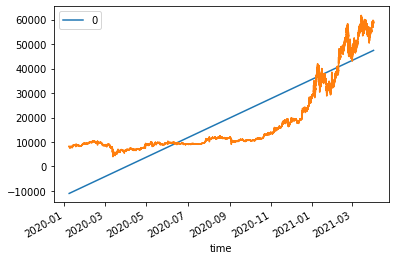

In [6]:
pd.DataFrame(p(date2num(df.close.index)), index=date2num(df.close.index)).plot()
df.close.plot()

In [9]:
import numpy as np

x = np.random.normal(3, 1, 100)
y = np.random.normal(1, 1, 100)

xedges = [0, 1, 1.5, 3, 5]
yedges = [0, 2, 3, 4, 6]

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

x2 = np.random.normal(3, 1, 100)
y2 = np.random.normal(1, 1, 100)

H += np.histogram2d(x2, y2, bins=(xedges, yedges))[0]


In [22]:
# Most frequent max-min per period
most_freq = {}
for i in (5, 15, 100, 360, 1440):
    a[f'var_{i}'] = (a.price.rolling(pd.Timedelta(f'{i}m')).max()
                     - a.price.rolling(pd.Timedelta(f'{i}m')).min()) / a.price
    count, x = np.histogram(a[f'var_{i}'].dropna(), bins=30)
    k = np.argmax(count)
    most_freq[i] = x[k], x[k+1]

In [32]:
np.polyfit(date2num(df.close[0:1]), df.close[0:1].values, 1)

/Users/felipe/pyenvs/research/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([4.32e+10, 4.15e+03])

In [33]:
date2num(pd.Timestamp('20150505'))

16560.0

In [3]:
prices = df.close

In [283]:
%%time
last_i = 0
err = 0.01
slope = np.zeros(len(prices))
running_slope = np.zeros(len(prices))
z = np.zeros(len(prices))
running_z = np.zeros(len(prices))
slope_return = np.zeros(len(prices))

meanX = date2num(prices.index[0])
meanY = prices.iloc[0]
n = 1
varX = covXY = a = b = 0
z[0] = meanY
running_z[0] = meanY

for i in range(1, len(prices)):
    x = date2num(prices.index[i])
    y = prices.iloc[i]
    
    fit_well = abs(a * x + b - y)/y <= err
    
    if not fit_well:
        z[last_i:i] = np.poly1d((a,b))(date2num(prices.index[last_i:i]))
        slope[last_i:i] = np.ones(i-last_i) * running_slope[i-1]
        slope_return[last_i:i] = (running_z[i-1] - running_z[last_i]) / running_z[last_i]
        last_i = i
        meanX = date2num(prices.index[i-1])
        meanY = prices.iloc[i-1]
        n = 1
        varX = covXY = a = b = 0
    
    n += 1
    dx = x - meanX
    dy = y - meanY
    varX += (((n-1)/n)*dx*dx - varX)/n
    covXY += (((n-1)/n)*dx*dy - covXY)/n
    meanX += dx/n
    meanY += dy/n

    a = covXY/varX
    b = meanY - a*meanX
            
    running_slope[i] = a
    running_z[i] = a * x + b

z[last_i:] = np.poly1d((a,b))(date2num(prices.index[last_i:]))
slope[last_i:] = np.ones(len(prices)-last_i) * running_slope[-1]
slope_return[last_i:] = (running_z[-1] - running_z[last_i]) / running_z[last_i]

CPU times: user 8.94 s, sys: 65.5 ms, total: 9.01 s
Wall time: 9.2 s


In [285]:
a = pd.DataFrame({'prices': df.close,
                  'z': z,
                  'running_z': running_z,
                  'slope': np.arctan(slope/10000) * 2/np.pi,
                  'running_slope': np.arctan(running_slope/10000) * 2/np.pi,
                  'slope_return': slope_return})

<AxesSubplot:xlabel='time'>

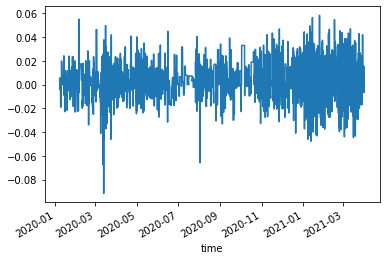

In [286]:
a.slope_return.plot()

<AxesSubplot:xlabel='time'>

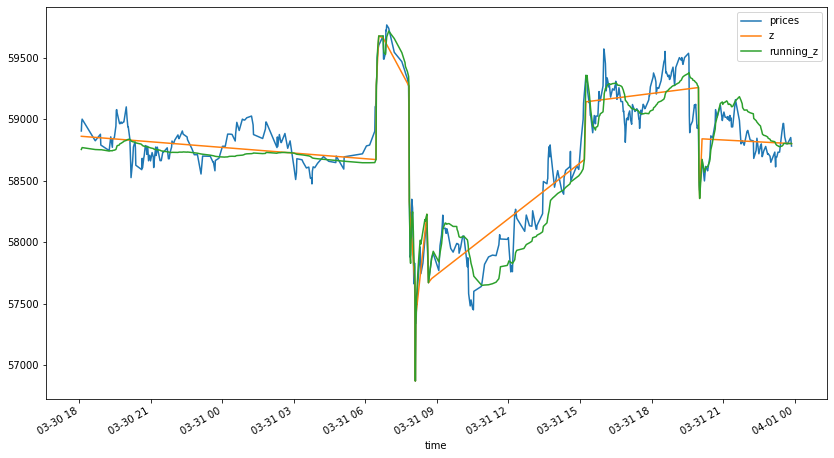

In [289]:
a[['prices', 'z', 'running_z']].iloc[-500:].plot(figsize=(14, 8))
#a['slope'].apply(np.log).iloc[-1000:].plot(figsize=(14, 4))
#(a[['slope']]*0).plot(figsize=(14, 4))

<AxesSubplot:xlabel='time'>

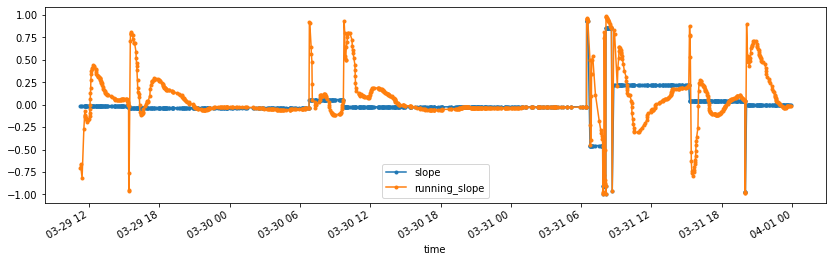

In [38]:
a[['slope', 'running_slope']].iloc[-1000:].plot(style='.-', figsize=(14, 4))

In [299]:
b = a[a.slope.values != a.slope.shift(-1)][['slope', 'slope_return']].copy()
b['time'] = b.index
b['duration'] = (b.time - b.time.shift()).dt.seconds / 60
b = b.dropna()
b.duration = b.duration.astype(int)
b.slope_return = b.slope_return.abs() >= 0.007

In [310]:
slope_bins = [-.9, -.5, 0, .5, .9]
duration_bins = np.linspace(20, 200, 5)

In [312]:
b['slope_bin'] = pd.cut(b.slope, slope_bins, include_lowest=True)
b['duration_bin'] = pd.cut(b.duration, duration_bins, include_lowest=True)
b = b.dropna()
b['bin'] = list(zip(b['slope_bin'], b['duration_bin'], b['slope_return']))

In [313]:
states = sorted(b.bin.unique())
states = pd.MultiIndex.from_tuples(states)

In [314]:
m = pd.DataFrame(np.zeros([len(states), len(states)]).astype(int), index=states, columns=states)

In [315]:
for i in range(1, len(b)):
    s1 = b.bin.iloc[i-1]
    s2 = b.bin.iloc[i]
    m.loc[s1, s2] += 1

In [318]:
len(states)

28

In [316]:
b.groupby('bin').count()

,slope,slope_return,time,duration,slope_bin,duration_bin
bin,,,,,,
"((-0.901, -0.5], (19.999, 65.0], False)",34,34,34,34,34,34
"((-0.901, -0.5], (19.999, 65.0], True)",129,129,129,129,129,129
"((-0.901, -0.5], (65.0, 110.0], False)",4,4,4,4,4,4
"((-0.901, -0.5], (65.0, 110.0], True)",29,29,29,29,29,29
"((-0.901, -0.5], (110.0, 155.0], True)",9,9,9,9,9,9
"((-0.901, -0.5], (155.0, 200.0], True)",5,5,5,5,5,5
"((-0.5, 0.0], (19.999, 65.0], False)",193,193,193,193,193,193
"((-0.5, 0.0], (19.999, 65.0], True)",57,57,57,57,57,57
"((-0.5, 0.0], (65.0, 110.0], False)",93,93,93,93,93,93


In [319]:
pd.options.display.max_columns = 30

In [321]:
(m.div(m.sum(axis=1), axis=0) * 100).astype(int).style.background_gradient()

## window drawdown

In [86]:
prices = df.close.copy()

In [ ]:
def smooth_out(prices, quantile=1e-4) -> None:
    d2 = prices.shift(-1) - 2*prices + prices.shift(1)
    q1 = d2.quantile(quantile)
    q2 = d2.quantile(1-quantile)
    prices[d2 < q1] = (prices.shift(-1) + prices.shift(1) - q1)/2
    prices[d2 > q2] = (prices.shift(-1) + prices.shift(1) - q2)/2

smooth_out(prices)

In [394]:
def add_duration(df) -> None:
    df['time'] = df.index
    df['duration'] = (df.time - df.time.shift()).dt.seconds
    df.dropna(inplace=True)
    df['duration'] = df['duration'].astype(int) // 60
    del df['time']

In [761]:
def discretize_log_prices(log_prices: pd.Series, increment) -> pd.Series:
    x = np.zeros(len(log_prices))
    y = log_prices.values
    last_p = y[0]
    for i, p in enumerate(y):
        if abs(p - last_p) >= increment:
            x[i] = p
            last_p = p
        else:
            x[i] = last_p
    x = pd.Series(x, index=log_prices.index)
    x.name = log_prices.name
    return x

In [910]:
def get_trend(prices, increment=0.01):
    # Return aggregated-discretized-log prices
    
    log_p = prices.apply(np.log)
    trend = discretize_log_prices(log_p, increment)
    trend.name = 'price'
    trend = trend.to_frame()
    trend = trend.dropna()
    
    trend['return'] = trend['price'].diff()
    trend.dropna(inplace=True)
    trend['trend'] = np.sign(trend['return'].values)
    # Remove consecutive same trend. Shift(-1) to keep the last
    trend = trend[trend.trend.values != trend.trend.shift(-1).values]
    # We have to calculate return again, because we removed elements
    trend['return'] = trend['price'].diff()
    trend.dropna(inplace=True)
    
    add_duration(trend)
    
    return trend

In [917]:
def add_pattern_label(trend, max_return=0.04, increment_return=0.005) -> None:
    # Add return label
    
    # We multiply by 1e3 to avoid rounding problems
    labels = np.arange(0, int(max_return*1e3) + 1, int(increment_return*1e3))/1e3
    labels = np.r_[-labels[-1:0:-1], labels]

    cut = np.r_[labels[:len(labels)//2], labels[len(labels)//2 + 1:]]
    # This is to not include the lower bond for negative numbers
    cut[cut < 0] += 1e-10

    assert len(cut)+1 == len(labels)

    t = np.digitize(trend['return'], cut)
    trend['pattern_label'] = labels[t]    

In [886]:
class Score(NamedTuple):
    freq: float
    num: int
    predictor: list
    predicted: float

In [887]:
def get_best_scores(N, threshold=0.7,
                    price_increment=0.01, filter_zero_ending=True) -> 'score, pattern':
    # N number of elements in the pattern
    # 0 < threshold < 1, score which the pattern is considered good
    # pattern = vector of pattern_label
    
    
    m = defaultdict(int)
    
    def f(s):
        m[tuple(s.values)] += 1
        return 0.
    
    _ = trend.rolling(N)['pattern_label'].apply(f)
    
    predictors = Counter(i[:len(i)-1] for i in m)
    
    def score(p):
        matches = {i:j for i,j in m.items() if p == i[:len(p)]}
        # We add +1 and +2 as a technique to avoid 100%, which is unrealistic
        score_ = (max(matches.values()) + 1) / (sum(matches.values()) + 2)
        best = max(matches, key=lambda k: matches[k])
        s = Score(freq=score_, num=matches[best], predictor=p, predicted=best[-1])
        return s
    
    scores = sorted((score(p) for p in predictors), reverse=True)
    scores = [i for i in scores if i.freq >= threshold]

    if filter_zero_ending:
        scores = [i for i in scores if i.predicted != 0.]
    
    return scores

In [888]:
def combine_best_scores(first_N=2, last_N=10):
    best_scores = []
    for i in range(first_N,last_N):
        best_scores = best_scores + get_best_scores(i)
        
    to_remove = []
    for i, s1 in enumerate(best_scores):
        b = s1.predictor
        for j, s2 in enumerate(best_scores):
            b2 = s2.predictor
            if len(b) > len(b2) and b2 == b[len(b)-len(b2):]:
                #print(f'Removing {b}, keeping {b2}')
                to_remove.append(i)
    
    for j in reversed(sorted(to_remove)):
        del best_scores[j]
    to_remove.clear()
    best_scores = list(reversed(sorted(best_scores)))
    
    return best_scores

In [896]:
num_trades = sum([i.num for i in best_scores])
freq = np.mean([i.freq for i in best_scores])
period = 365 / (prices.index[-1] - prices.index[0]).days

In [904]:
APY = (3*freq - 2) * num_trades * period * 0.01
APY

0.3548698991670535

In [901]:
num_trades

163

In [905]:
0.7 * 120 * 0.01 - 2 * 0.3 * 120 * 0.01

0.12

In [909]:
(0.75 - 2 * 0.25) * 120 * 0.01

0.3

In [908]:
freq

0.7557395382395383

In [855]:
R * N * profit - 2*(1-R) * N * profit =
R - 2*(1-R) > 0
R - 2 + 2*R > 0
3*R > 2
R > 2/3

0.09776785714285714

In [846]:
def predict(returns, best_scores):
    returns = tuple(returns)
    for s in best_scores:
        seq, prediction = s.predictor, s.predicted
        size_diff = len(seq) - len(returns)
        seq = seq[max(size_diff, 0):]
        r = returns[max(-size_diff, 0):]
        assert len(r) == len(seq)
        if r == seq:
            return prediction
        

In [849]:
predict((-0.01, 0.0, -0.02, 0.0, 0.01, 0.0, 0.01, 0.0), best_scores)

0.01

In [845]:
m

defaultdict(int,
            {(0.0, 0.01, -0.01, 0.0, 0.01, 0.0, -0.02, 0.0, -0.01): 1,
             (0.01, -0.01, 0.0, 0.01, 0.0, -0.02, 0.0, -0.01, 0.01): 1,
             (-0.01, 0.0, 0.01, 0.0, -0.02, 0.0, -0.01, 0.01, -0.01): 1,
             (0.0, 0.01, 0.0, -0.02, 0.0, -0.01, 0.01, -0.01, 0.0): 2,
             (0.01, 0.0, -0.02, 0.0, -0.01, 0.01, -0.01, 0.0, -0.03): 1,
             (0.0, -0.02, 0.0, -0.01, 0.01, -0.01, 0.0, -0.03, 0.04): 1,
             (-0.02, 0.0, -0.01, 0.01, -0.01, 0.0, -0.03, 0.04, 0.0): 1,
             (0.0, -0.01, 0.01, -0.01, 0.0, -0.03, 0.04, 0.0, 0.01): 1,
             (-0.01, 0.01, -0.01, 0.0, -0.03, 0.04, 0.0, 0.01, 0.0): 1,
             (0.01, -0.01, 0.0, -0.03, 0.04, 0.0, 0.01, 0.0, -0.01): 1,
             (-0.01, 0.0, -0.03, 0.04, 0.0, 0.01, 0.0, -0.01, 0.0): 1,
             (0.0, -0.03, 0.04, 0.0, 0.01, 0.0, -0.01, 0.0, -0.01): 1,
             (-0.03, 0.04, 0.0, 0.01, 0.0, -0.01, 0.0, -0.01, 0.0): 1,
             (0.04, 0.0, 0.01, 0.0, -0.01, 0.0, 

# Github Package

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

/Users/felipe/pyenvs/research/lib/python3.9/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
import backtesting

In [6]:
from backtesting.test import SMA, GOOG


In [15]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'trades'], dtype='object')

In [16]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Trades']

In [19]:
len(df.iloc[:4000])

4000

In [22]:
from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

In [44]:
Backtest.plot()

TypeError: plot() missing 1 required positional argument: 'self'

## Kraken download

In [4]:
import krakenex
from pykrakenapi import KrakenAPI
api = krakenex.API()
k = KrakenAPI(api)

    

                           time     open     high      low    close     vwap  \
dtime                                                                          
2021-05-31 02:21:00  1622427660  34637.1  34637.1  34637.0  34637.0  34637.0   
2021-05-31 02:20:00  1622427600  34663.6  34690.5  34637.0  34637.0  34681.0   
2021-05-31 02:19:00  1622427540  34708.6  34708.6  34636.9  34658.8  34648.6   
2021-05-31 02:18:00  1622427480  34714.9  34752.3  34714.9  34717.8  34735.5   
2021-05-31 02:17:00  1622427420  34766.9  34766.9  34727.5  34740.8  34748.9   
...                         ...      ...      ...      ...      ...      ...   
2021-05-30 14:26:00  1622384760  35317.0  35317.0  35186.8  35195.0  35274.7   
2021-05-30 14:25:00  1622384700  35249.9  35319.0  35249.9  35319.0  35311.0   
2021-05-30 14:24:00  1622384640  35400.0  35400.0  35235.7  35255.2  35295.7   
2021-05-30 14:23:00  1622384580  35499.8  35499.8  35400.0  35400.2  35454.5   
2021-05-30 14:22:00  1622384520  35460.9

In [30]:
int(pd.Timestamp('20210101 00:02:00').timestamp())

1609459320

In [35]:
pd.Timestamp(1548111600 * 1e9)

Timestamp('2019-01-21 23:00:00')

In [18]:
k.get_ohlc_data?

In [53]:
import requests

start = '2021-03-31 23:52:00'
end = '2021-05-30 23:00:00'

start = int(pd.Timestamp(start).timestamp()) * 1e9
end = int(pd.Timestamp(end).timestamp()) * 1e9
last = start

In [71]:
final = []
while True:
    resp = requests.get(f'https://api.kraken.com/0/public/Trades?pair=BTCUSD&since={last}')
    r = resp.json()
    if r['error']:
        raise Exception(r['error'])
    r = r['result']
    last = r['last']
    final = final + r['XXBTZUSD']
    print(f'final is {pd.Timestamp(int(last))}')
    sleep(2.1)

final is 2021-05-31 03:25:18.440343286
final is 2021-05-31 03:25:34.441017768
final is 2021-05-31 03:25:36.091200362
final is 2021-05-31 03:25:36.091200362
final is 2021-05-31 03:25:36.091200362
final is 2021-05-31 03:25:43.947763132
final is 2021-05-31 03:25:43.947763132
final is 2021-05-31 03:25:43.947763132
final is 2021-05-31 03:25:52.064616794


KeyboardInterrupt: 

In [70]:
pd.Timestamp(1622431239065055006)

Timestamp('2021-05-31 03:20:39.065055006')